<a href="https://colab.research.google.com/github/Mikhail-Klochkov/train_/blob/master/Reduction_NN_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

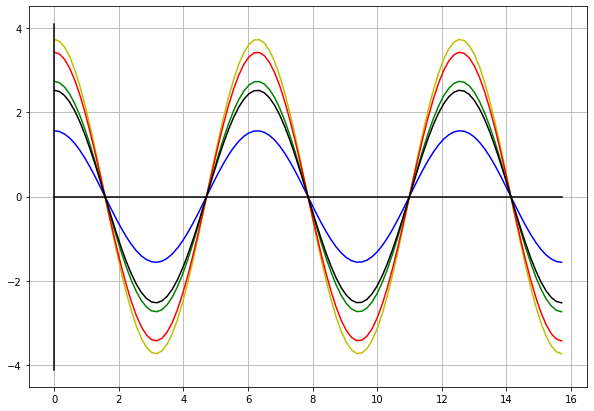

In [ ]:
import numpy as np
import torch 
import random 
import matplotlib.pyplot as plt


# -- n points for generated signal -- #
n_points_of_range = 100
# -- for additive noise -- #
Sigma = 0.1
# -- left bound of interval x -- #
a = 0.
# -- right bound of interval x -- #
b = 5 * np.pi
# -- XRANGE -- #
XRANGE = np.linspace(a,b, n_points_of_range)

# -- generate or signal -- #
def funct(x, A):
  """
  A is constant
  x is array of range one dimension
  """
  return A * np.cos(x)

def generate_different_signals(xrange, 
                               samples, 
                               with_noise = False):
  """
  xrange np.ndarray of 1 dimension, samples is numbers of genereted samples
  with_noise - is flag for identification additive noise in our signal
  model:
        A ~ U[a1, a2] is Uniform distribution
  """
  a1, a2 = 1., 5.
  A_coefs = np.random.random(size = samples) * (a2 - a1) + a1
  # -- for each A we generate sample of -- #
  f_batch_signals = np.array([
                     funct(xrange, A)
                     for A in A_coefs
  ])
  return f_batch_signals

def show_graphs(f_list):
    if(len(f_list.shape) == 1):
        f_list = f_list[np.newaxis,:]
        print(f_list.shape)

    assert(f_list.shape[1] == n_points_of_range)
    color_list = ['b', 'y', 'g', 'r', 'black', 'gray']
    fig, ax = plt.subplots(figsize = (10, 7))       
    for idx in range(f_list.shape[0] if f_list.shape[0] <= 5 else 5):
        ax.plot(XRANGE,f_list[idx], c = color_list[idx])
    ax.grid()
    ax.plot(np.zeros((n_points_of_range, )), 
            np.linspace(ax.get_ylim()[0], 
                        ax.get_ylim()[1],
                        n_points_of_range), 
            c = 'black')
    ax.plot(XRANGE, np.zeros((n_points_of_range, )), c = 'black')

def show_graphs_labels(f_list, 
                       labels: list):
    if(len(f_list.shape) == 1):
        f_list = f_list[np.newaxis,:]
        print(f_list.shape)

    assert(f_list.shape[1] == n_points_of_range)
    color_list = ['b', 'y', 'g', 'r', 'black', 'gray']
    fig, ax = plt.subplots(figsize = (10, 7))       
    for idx in range(f_list.shape[0] if f_list.shape[0] <= 5 else 5):
        ax.plot(XRANGE,f_list[idx],
                c = color_list[idx], 
                label = labels[idx])
        
        ax.legend()
    #ax.legend()
    ax.grid()
    ax.plot(np.zeros((n_points_of_range, )), 
            np.linspace(ax.get_ylim()[0], 
                        ax.get_ylim()[1],
                        n_points_of_range), 
            c = 'black')
    ax.plot(XRANGE, np.zeros((n_points_of_range, )), c = 'black')



# -- create batch of signals from set of possible signals -- #
f_batch = generate_different_signals(XRANGE, 
                           samples = 5, 
                           with_noise = False)
# -- show some generated signals on screen -- #
show_graphs(f_batch)

Выше сгенерировано семейство кривых, где A * cos(X), где X - это множество точек прямой. А ~ U(a, b), a = 0, b = 5*pi.

In [ ]:
# -- определим матрицу в соотвествии с которой мы будет преобразовывать сигнал -- #
def getWeights(lenght = 7.,
            C = 2.,
            sigma = 2.):
  """
  create weights of kernel
  """
  if(lenght % 2 == 0):
    print('Need 2k + 1, where k = 0,1,2...')
  expfunct = lambda x: C * np.exp(- (x ** 2/(2 * sigma ** 2))) 
  range_local = np.arange(-3, 4, step = 1)
  return expfunct(range_local)

def shift(lst: list, steps: int):
  """
  step can be positive and negative
  """
  if(steps < 0):
    steps = abs(steps)
    for i in range(steps):
      lst.append(lst.pop(0))
  else:
    for i in range(steps):
      lst.insert(0, lst.pop())
  
  return lst

def getAOperator(weights: np.ndarray):
  """
  weights is weigth get from weights function
  crate some A operator
  see definition
  """
  A = np.empty((n_points_of_range, n_points_of_range), 
               dtype = np.float32)
  # -- fill each row of matrix A -- #
  list_of_weights = list(weights)
  list_row = [0] * n_points_of_range
  list_row[:len(list_of_weights)] = list_of_weights
  list_row = shift(list_row, -3)
  for idx in range(n_points_of_range):
    A[idx, :] = np.array(list_row, dtype = np.float32)
    list_row = shift(list_row, 1)
  return A

weights = getWeights()
A = getAOperator(weights)

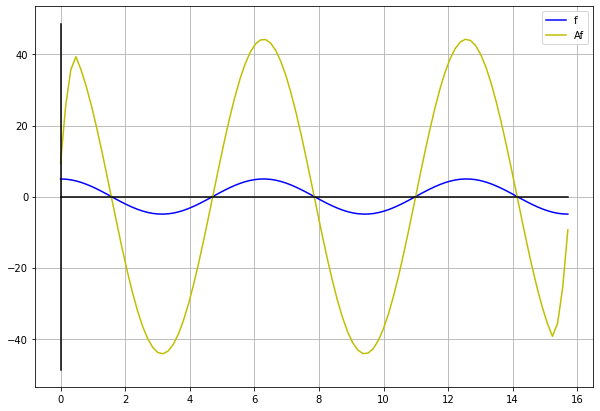

In [ ]:
# -- see on Af signal -- #

f_one = generate_different_signals(XRANGE, samples =  1)
Af = A @ f_one.squeeze()
pair = np.array(np.vstack((f_one, Af)))
show_graphs_labels(pair, ['f', 'Af'])

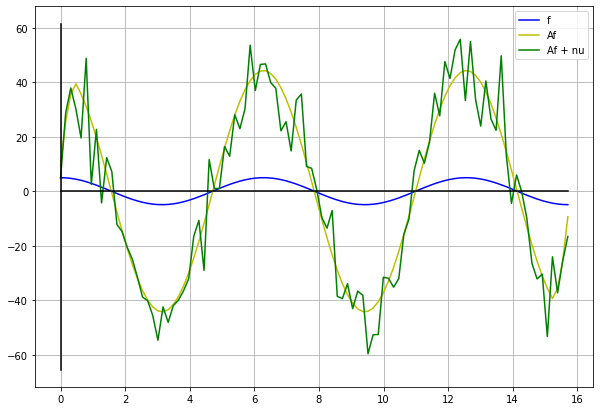

In [ ]:
# -- choose model of noise -- #

# -- non correlated simple white noise with Sigma ** 2 -- #
Sigma = 3.
noise = np.random.randn(n_points_of_range) * Sigma ** 2

xi = A @ f_one.squeeze() + noise
trio = np.array(np.vstack((pair, xi)))
show_graphs_labels(trio, ['f', 'Af', 'Af + nu'])


In [ ]:
# -- generate dataset -- #
N = 500
train_size = 0.7
data_f = generate_different_signals(XRANGE, 
                                    samples = N)
# -- for each we create A * f + noise -- #
data_xi = np.empty(data_f.shape)
for idx in range(N):
  noise = np.random.randn(n_points_of_range) * Sigma ** 2
  data_xi[idx, :] = A @ data_f[idx, :].squeeze() + noise

# -- shuffle our data -- #
split_index = int(train_size * N)
train_f = data_f[:split_index]
test_f = data_f[split_index: ]

train_xi = data_xi[:split_index]
test_xi = data_xi[split_index: ]

In [ ]:
# -- we should torch objects create -- #
train_xi_t = torch.from_numpy(train_xi)
train_f_t = torch.from_numpy(train_f)

test_xi_t = torch.from_numpy(test_xi)
test_f_t = torch.from_numpy(test_f)

train_xi_t = train_xi_t.type(torch.float32)
train_f_t = train_f_t.type(torch.float32)

test_xi_t = test_xi_t.type(torch.float32)
test_f_t = test_f_t.type(torch.float32)


In [ ]:
# -- create architecture -- #
D_in = n_points_of_range
D_out = n_points_of_range
H = 200
model_nonlinear = torch.nn.Sequential(
                torch.nn.Linear(D_in, H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = 0.5),
                torch.nn.Linear(H, D_out)
                
)
model_lin = torch.nn.Sequential(
                torch.nn.Linear(D_in, D_out)            
)

Обучение нейронной сети с одним скрытым слоем и Дропаутом (своего рода регуляризация).

In [ ]:
# -- nonlinear case -- #
# -- learning our network -- #
from torch.utils.data import DataLoader, Dataset

criterion = torch.nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.Adam(model_nonlinear.parameters(), 
                             lr = 0.001 * 3)

class Dataown(Dataset):

  def __init__(self, xiarr, farr):
    assert(xiarr.shape[0] == farr.shape[0])
    self._xi = xiarr
    self._f = farr

  def __len__(self):
    return len(self._xi)

  def __getitem__(self, idx):
    return self._f[idx, :], self._xi[idx, :]


train_data = Dataown(train_xi_t, train_f_t)
loader = DataLoader(train_data, batch_size = 50, shuffle = True)

val_data = Dataown(test_xi_t, test_f_t)
val_loader = DataLoader(val_data, 
                    batch_size = 50, 
                    shuffle = True)

erorr_test_before = 1e9
times = 0
t = 5
for t in range(200):
    for f, xi in loader:

      optimizer.zero_grad()
      f_pred = model_nonlinear(xi)
      loss = criterion(f_pred, f)  
      loss.backward()
      optimizer.step()

      # -- evalution on test set data -- #
    with torch.no_grad():
      model_nonlinear.eval()
      for f_val, xi_val in val_loader:
        f_pred_test = model_nonlinear(test_xi_t)
        test_loss = criterion(f_pred_test, test_f_t)

    if(t % 10 == 0):
      print("iter: {} train mse: {:.2f} test mse: {:.2f}".format(t, 
                                                                 loss.item(),
                                                                 test_loss.item()))
      # -- update learning rate parameter -- #
      optimizer.param_groups[0]['lr'] *= 0.98

    if(erorr_test_before > test_loss):
       times = 0
       erorr_test_before = test_loss
    else:
      times += 1
      if(times > t):
        print('Минимум при данных параметрах достигнут!')
        print("before: {:.2f}, after: {:.2f}".format(erorr_test_before, 
                                                    test_loss))
      
        break


iter: 0 train mse: 24206.09 test mse: 68455.44
iter: 10 train mse: 360.72 test mse: 1626.54
iter: 20 train mse: 143.83 test mse: 779.39
iter: 30 train mse: 69.75 test mse: 544.67
iter: 40 train mse: 53.50 test mse: 433.47
iter: 50 train mse: 38.99 test mse: 392.90
iter: 60 train mse: 58.45 test mse: 361.37
iter: 70 train mse: 40.17 test mse: 341.68
iter: 80 train mse: 28.36 test mse: 338.95
iter: 90 train mse: 26.12 test mse: 351.89
iter: 100 train mse: 28.95 test mse: 341.13
iter: 110 train mse: 28.96 test mse: 362.88
iter: 120 train mse: 33.90 test mse: 364.69
iter: 130 train mse: 32.85 test mse: 361.99
iter: 140 train mse: 20.85 test mse: 342.06
iter: 150 train mse: 29.03 test mse: 342.26
iter: 160 train mse: 28.96 test mse: 346.93
iter: 170 train mse: 24.86 test mse: 356.30
iter: 180 train mse: 27.18 test mse: 362.39
iter: 190 train mse: 21.11 test mse: 360.37


In [ ]:

class Dataown(Dataset):

  def __init__(self, xiarr, farr):
    assert(xiarr.shape[0] == farr.shape[0])
    self._xi = xiarr
    self._f = farr

  def __len__(self):
    return len(self._xi)

  def __getitem__(self, idx):
    return self._f[idx, :], self._xi[idx, :]


train_data = Dataown(train_xi_t, train_f_t)
loader = DataLoader(train_data, batch_size = 50, shuffle = True)


for f, xi in loader:
  print(f.shape, xi.shape)


torch.Size([50, 100]) torch.Size([50, 100])
torch.Size([50, 100]) torch.Size([50, 100])
torch.Size([50, 100]) torch.Size([50, 100])
torch.Size([50, 100]) torch.Size([50, 100])
torch.Size([50, 100]) torch.Size([50, 100])
torch.Size([50, 100]) torch.Size([50, 100])
torch.Size([50, 100]) torch.Size([50, 100])


Обучение нейронной сети с одним линейным слоем.

In [ ]:
model_lin = torch.nn.Sequential(
                torch.nn.Linear(D_in, D_out)            
)

In [ ]:
# -- nonlinear case -- #
# -- learning our network -- #
from torch.utils.data import DataLoader, Dataset

criterion = torch.nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.Adam(model_lin.parameters(), 
                             lr = 0.001 * 3)

class Dataown(Dataset):

  def __init__(self, xiarr, farr):
    assert(xiarr.shape[0] == farr.shape[0])
    self._xi = xiarr
    self._f = farr

  def __len__(self):
    return len(self._xi)

  def __getitem__(self, idx):
    return self._f[idx, :], self._xi[idx, :]


train_data = Dataown(train_xi_t, train_f_t)
loader = DataLoader(train_data, batch_size = 50, shuffle = True)

val_data = Dataown(test_xi_t, test_f_t)
val_loader = DataLoader(val_data, 
                    batch_size = 50, 
                    shuffle = True)

erorr_test_before = 1e9
times = 0
t = 5

for t in range(300):
  sum_all_batchs_train = 0
  sum_all_batchs_test = 0
  times_tr = 0
  for f, xi in loader:
      times_tr += 1
      optimizer.zero_grad()
      f_pred = model_lin(xi)
      loss = criterion(f_pred, f)  
      loss.backward()
      optimizer.step()

      sum_all_batchs_train += loss

      # -- evalution on test set data -- #
  with torch.no_grad():
    model_lin.eval()
    times_ts = 0
    for f_val, xi_val in val_loader:
      f_pred_test = model_lin(test_xi_t)
      test_loss = criterion(f_pred_test, test_f_t)
      sum_all_batchs_test += loss
      times_ts += 1

  if(t % 10 == 0):
    """
    print("iter: {} train mse: {:.2f} test mse: {:.2f}".format(t, 
                                                                loss.item(),
                                                                test_loss.item()))
    """
    print("iter: {} train mse: {:.2f} test mse: {:.2f}".format(t, 
                                                                sum_all_batchs_train/times_tr,
                                                                sum_all_batchs_test/times_ts))
    # -- update learning rate parameter -- #
    optimizer.param_groups[0]['lr'] *= 0.98

  if(erorr_test_before > test_loss):
      times = 0
      erorr_test_before = test_loss
  else:
    times += 1
    if(times > t):
      print('Минимум при данных параметрах достигнут!')
      print("before: {:.2f}, after: {:.2f}".format(erorr_test_before, 
                                                   test_loss))
      
      break


iter: 0 train mse: 323598.84 test mse: 240438.14
iter: 10 train mse: 53550.35 test mse: 53234.14
iter: 20 train mse: 24028.88 test mse: 22735.10
iter: 30 train mse: 11697.56 test mse: 11225.81
iter: 40 train mse: 6048.30 test mse: 5917.44
iter: 50 train mse: 3251.32 test mse: 3249.11
iter: 60 train mse: 1825.07 test mse: 1869.05
iter: 70 train mse: 1074.93 test mse: 1049.37
iter: 80 train mse: 639.34 test mse: 570.10
iter: 90 train mse: 399.93 test mse: 352.61
iter: 100 train mse: 260.33 test mse: 257.18
iter: 110 train mse: 173.64 test mse: 156.99
iter: 120 train mse: 128.75 test mse: 143.56
iter: 130 train mse: 94.69 test mse: 116.44
iter: 140 train mse: 78.53 test mse: 77.25
iter: 150 train mse: 64.95 test mse: 69.84
iter: 160 train mse: 56.07 test mse: 45.39
iter: 170 train mse: 52.26 test mse: 45.01
iter: 180 train mse: 53.08 test mse: 59.28
iter: 190 train mse: 43.97 test mse: 52.06
iter: 200 train mse: 46.11 test mse: 55.22
iter: 210 train mse: 46.97 test mse: 38.59
iter: 220 tr

In [ ]:
# -- Может быть сравнить с Редукцией  -- #
def estCovarianceMatrix(samples):
  """
  samples - is np.ndarray with N examples generated from space of parameters
  samples is matrix (N, n) 
  """
  mean = samples.mean(axis = 0)
  dx = samples - mean
  return mean, (1/(samples.shape[0] - 1)) * np.dot(dx.T, dx)

f_arrays = generate_different_signals(XRANGE, 
                                     samples = 5000)
f_0, F = estCovarianceMatrix(f_arrays)


In [ ]:
def estf(model: tuple, xi):
  """
  estimate f signal by xi
  """
  A, S_nu, f_0, F = model
  Q = np.dot(A, np.dot(F, A.T)) + np.linalg.inv(S_nu)
  return f_0 + np.dot(np.dot(F, np.dot(A.T, np.linalg.inv(Q))), xi - np.dot(A, f_0))


def getR(model: tuple):
  A, S_nu, f_0, F = model
  Q = np.dot(A, np.dot(F, A.T)) + np.linalg.inv(S_nu)
  return np.dot(F, np.dot(A.T, np.linalg.inv(Q))), f_0 - np.dot(np.dot(F, np.dot(A.T, np.linalg.inv(Q))), np.dot(A, f_0))


def getRn(model: tuple):
  A, S_nu, f_0, F = model
  Q = np.dot(A, np.dot(F, A.T)) + np.linalg.inv(S_nu)
  return 0.5 * np.dot(F, np.dot(A.T, np.linalg.inv(Q))), f_0 - np.dot(np.dot(F, np.dot(A.T, np.linalg.inv(Q))), np.dot(A, f_0))

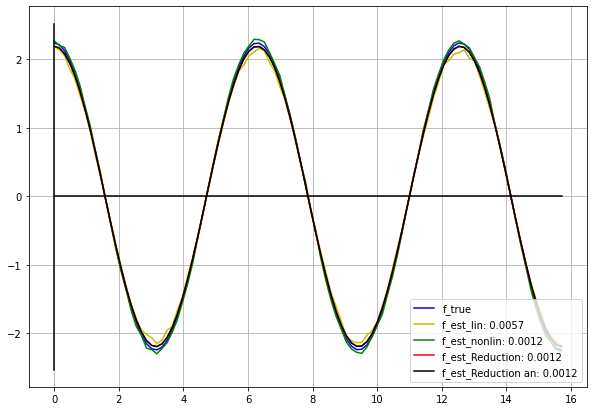

In [ ]:
# -- results -- #
# -- we train or models -- #
# -- model_linear -- #

def meanSquareError(a, b):
  """
  Calculate MSE between two vectors
  a, b - is np.ndarray
  """
  return np.square((a - b)).sum()/a.shape[0]

# -- Вытаскиваем случайный пример для демонстрации результата -- #
sample = np.random.randint(0, test_f.shape[0], size = 1)[0]
f_see = test_f[sample]
xi_see = test_xi[sample]

# -- preds -- #
# -- pred linear -- #
f_see_t = torch.from_numpy(f_see).type(torch.float32)
xi_see_t = torch.from_numpy(xi_see).type(torch.float32)

f_pred_linear = model_lin(xi_see_t).detach().numpy()
# -- pred nonlinear -- #
f_pred_nonlinear = model_nonlinear(xi_see_t).detach().numpy()

# -- preds for Reduction -- #
modelred = (A, np.eye(n_points_of_range) * Sigma ** 2, f_0, F)
f_redest = estf(modelred, xi_see)

# -- calculate concrete MSE for each prediction value -- #

mselin = meanSquareError(f_see, f_pred_linear)
msenonlin = meanSquareError(f_see, f_pred_nonlinear) 
msered = meanSquareError(f_see, f_redest)
R_get, r_get = getR(modelred)
f_true_another = R_get @ xi_see + r_get
mseredan = meanSquareError(f_see, f_true_another)


show_graphs_labels(np.vstack([f_see, 
                              f_pred_linear, 
                              f_pred_nonlinear,
                              f_redest,
                              f_true_another]),
                              ['f_true', 
                               'f_est_lin: {:.4f}'.format(mselin),
                               'f_est_nonlin: {:.4f}'.format(msenonlin),
                               'f_est_Reduction: {:.4f}'.format(msered),
                               'f_est_Reduction an: {:.4f}'.format(mseredan),
                               ])

In [ ]:
# -- Явно вытащить параметры линейной модели  -- #

R = np.empty((n_points_of_range, n_points_of_range))
r = np.empty((n_points_of_range, ))
for param in model_lin.parameters():
  if(param.shape.__len__() == 2):
    R = param.detach().numpy()
  else:
    r = param.detach().numpy()
    
R

array([[ 0.00103148,  0.00234854,  0.00240164, ..., -0.00116205,
        -0.00281037, -0.00168847],
       [ 0.00137403,  0.0020578 ,  0.00234477, ..., -0.00119387,
        -0.00281937, -0.00141626],
       [ 0.00115409,  0.00179671,  0.00222604, ..., -0.0016226 ,
        -0.00299294, -0.00166766],
       ...,
       [-0.00101752, -0.0019257 , -0.00205745, ...,  0.00107908,
         0.0025812 ,  0.0014534 ],
       [-0.00121404, -0.00185459, -0.00215211, ...,  0.00116873,
         0.00255413,  0.00154865],
       [-0.00130035, -0.00212174, -0.00253542, ...,  0.0012229 ,
         0.0028988 ,  0.00152254]], dtype=float32)

In [ ]:
np.linalg.norm(R - A)/np.linalg.norm(A)

0.9993111

In [ ]:
R_best, r_best = getR(modelred)
error_matrix = np.linalg.norm(R - R_best)/np.linalg.norm(R_best)
erorr_vect = np.linalg.norm(r_best - r)/np.linalg.norm(r_best)

print("Относительная ошибка: {:.3f}".format(error_matrix))

Относительная ошибка: 0.651


Здесь мы смотрим на среднюю квадратичную ошибку по всем примерам из тестовой части.

In [ ]:
# -- mean by dataset -- #

test_f
test_xi
sum_lin = 0
sum_red = 0
sum_nonlin = 0

for idx in range(test_xi.shape[0]):
  current_xi_t = torch.from_numpy(test_xi[idx]).type(torch.float32)
  sum_lin += meanSquareError(model_lin(current_xi_t).detach().numpy(), test_f[idx])
  sum_red += meanSquareError(estf(modelred, test_xi[idx]), test_f[idx])
  sum_nonlin += meanSquareError(model_nonlinear(current_xi_t).detach().numpy(), test_f[idx])

print('average NN linear layer: {:.3f}'.format(sum_lin/test_f.shape[0]))
print('average Reduction: {:.3f}'.format(sum_red/test_f.shape[0]))
print('average NN nonlinear with one hidden layer: {:.3f}'.format(sum_nonlin / test_f.shape[0]))


average NN linear layer: 0.015
average Reduction: 0.012
average NN nonlinear with one hidden layer: 0.028
